In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

df_coforge=pd.read_csv('/content/COFORGE.NS.csv')
df_hcl=pd.read_csv('/content/HCLTECH.NS.csv')
df_tcs=pd.read_csv('/content/TCS.NS.csv')
df_ltim=pd.read_csv('/content/LTIM.NS.csv')
df_mphasis=pd.read_csv('/content/MPHASIS.NS.csv')
df_persistent=pd.read_csv('/content/PERSISTENT.NS.csv')
df_techm=pd.read_csv('/content/TECHM.NS.csv')
df_wipro=pd.read_csv('/content/WIPRO.NS.csv')
df_infy=pd.read_csv('/content/infosys.csv')



df_concat=pd.concat([df_hcl['Adj Close'],df_tcs['Adj Close'],df_coforge['Adj Close'],df_ltim['Adj Close'],
                     df_mphasis['Adj Close'],df_persistent['Adj Close'],df_techm['Adj Close'],df_wipro['Adj Close'],df_infy['Adj Close']],axis=1)
df_concat.columns=['HCL','TCS','COFORGE','LTIM','MPHASIS','PERSISTENT','TECHM','WIPRO','INFOSYS']

#calculate correlation matrix
correl_matrix=df_concat.corr()


# Extract the upper triangle of the correlation matrix
upper_tri = correl_matrix.where(np.triu(np.ones(correl_matrix.shape), k=1).astype(bool))

# Unstack the upper triangle matrix and reset the index to get a DataFrame of pairs
pairs = upper_tri.unstack().reset_index()

# Rename the columns for easier understanding
pairs.columns = ['Variable1', 'Variable2', 'Correlation']

# Sort the pairs by the correlation value in descending order and drop NaN values
top_pairs = pairs.sort_values(by='Correlation', ascending=False).dropna()

# Select the top 10 pairs
top_10_pairs = top_pairs.head(10)

print(top_10_pairs)



     Variable1 Variable2  Correlation
18     COFORGE       HCL     0.971938
75     INFOSYS      LTIM     0.969380
45  PERSISTENT       HCL     0.968192
58       TECHM   MPHASIS     0.967894
39     MPHASIS      LTIM     0.967603
9          TCS       HCL     0.967527
57       TECHM      LTIM     0.967001
73     INFOSYS       TCS     0.965752
19     COFORGE       TCS     0.963982
76     INFOSYS   MPHASIS     0.957615


In [32]:
# Calculate the log prices
df_concat_log = np.log(df_concat)
print(df_concat.head())
hedge_ratio_list=[]

for i in range(len(top_10_pairs)):
     log_prices_A = df_concat_log[top_10_pairs.iloc[i,0]]
     log_prices_B = df_concat_log[top_10_pairs.iloc[i,1]]
     # Add a constant term for the intercept
     log_prices_B_with_const = sm.add_constant(log_prices_B)

     #Perform OLS regression
     model = sm.OLS(log_prices_A, log_prices_B_with_const)
     results = model.fit()

     # Extract the hedge ratio
     hedge_ratio = results.params[1]

     df_hedge_ratio=pd.DataFrame()
     hedge_ratio_list.append([top_10_pairs.iloc[i,0],top_10_pairs.iloc[i,1],hedge_ratio])
columns=['stock_a','stock_b','HEDGE_RATIO']
hedge_ratio_dataframe=pd.DataFrame(hedge_ratio_list,columns=columns)


          HCL          TCS     COFORGE         LTIM     MPHASIS  PERSISTENT  \
0  367.974823  1152.955688  602.737854  1043.743164  626.322266  328.376862   
1  373.879425  1146.679932  592.366699  1047.023926  623.268127  327.154358   
2  375.763916  1149.926636  595.501038  1024.971558  610.881592  321.087769   
3  374.005219  1157.967407  602.138611  1030.211182  607.318420  326.854431   
4  376.915588  1171.956665  617.211792  1010.118164  605.748901  331.975250   

        TECHM       WIPRO     INFOSYS  
0  414.378296  231.120148  441.161621  
1  423.314972  232.689926  439.518219  
2  427.845093  226.301331  435.932770  
3  430.398315  227.542557  433.414429  
4  432.786926  226.009308  431.963135  


In [40]:
hedge_ratio_dataframe

,stock_a,stock_b,HEDGE_RATIO
0,COFORGE,HCL,1.444026
1,INFOSYS,LTIM,0.750166
2,PERSISTENT,HCL,2.112686
3,TECHM,MPHASIS,0.668712
4,MPHASIS,LTIM,0.866231
5,TCS,HCL,0.713277
6,TECHM,LTIM,0.591912
7,INFOSYS,TCS,1.287310
8,COFORGE,TCS,1.975891
9,INFOSYS,MPHASIS,0.825293


In [41]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

list_of_pvalue=[]

for i in range(len(hedge_ratio_dataframe)):
  log_prices_A = df_concat_log[hedge_ratio_dataframe.iloc[i,0]]
  log_prices_B = df_concat_log[hedge_ratio_dataframe.iloc[i,1]]
  # Hedge ratio
  n = hedge_ratio_dataframe.iloc[i,2]

  # Calculate the spread
  spread = log_prices_A - n * log_prices_B

  # Perform ADF test on the spread
  adf_result = adfuller(spread,autolag='AIC')

  # Extract results
  adf_statistic = adf_result[0]
  p_value = adf_result[1]
  critical_values = adf_result[4]


  list_of_pvalue.append([hedge_ratio_dataframe.iloc[i,0],hedge_ratio_dataframe.iloc[i,1],n,top_10_pairs.iloc[i,2],p_value,adf_statistic])

dataframe_of_p_values=pd.DataFrame(list_of_pvalue,columns=['stock_a','stock_b','hedge_ratio','correlation','p_value','test_statics'])
print(dataframe_of_p_values)

print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

# Interpret the result
if p_value < 0.1:
    print("The spread is stationary (reject the null hypothesis).")
else:
    print("The spread is not stationary (fail to reject the null hypothesis).")
# as test static is more than<= critical values of 1%,5%,10%
#it  mean that we can say spread is staionary with 1%,5%,10% significance levels

      stock_a  stock_b  hedge_ratio  correlation   p_value  test_statics
0     COFORGE      HCL     1.444026     0.971938  0.004898     -3.648515
1     INFOSYS     LTIM     0.750166     0.969380  0.001038     -4.081746
2  PERSISTENT      HCL     2.112686     0.968192  0.023081     -3.149796
3       TECHM  MPHASIS     0.668712     0.967894  0.012323     -3.362047
4     MPHASIS     LTIM     0.866231     0.967603  0.016190     -3.271739
5         TCS      HCL     0.713277     0.967527  0.000186     -4.513215
6       TECHM     LTIM     0.591912     0.967001  0.040768     -2.941147
7     INFOSYS      TCS     1.287310     0.965752  0.016438     -3.266625
8     COFORGE      TCS     1.975891     0.963982  0.000264     -4.428554
9     INFOSYS  MPHASIS     0.825293     0.957615  0.042221     -2.927699
Critical Values:
   1%: -3.434403043188966
   5%: -2.863330182785859
   10%: -2.567723055843177
The spread is stationary (reject the null hypothesis).


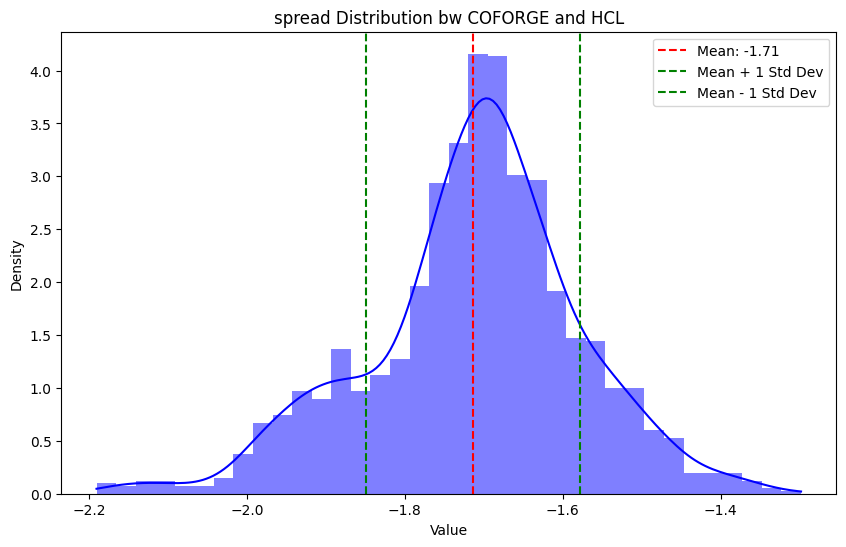

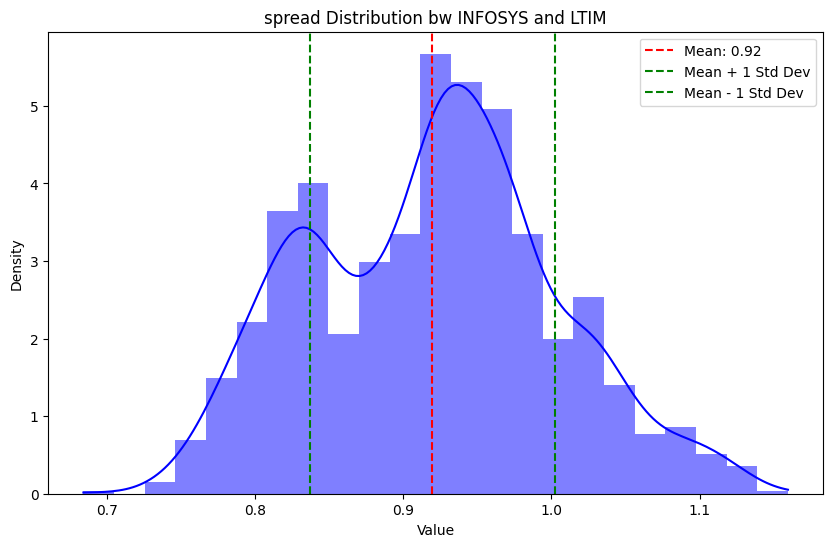

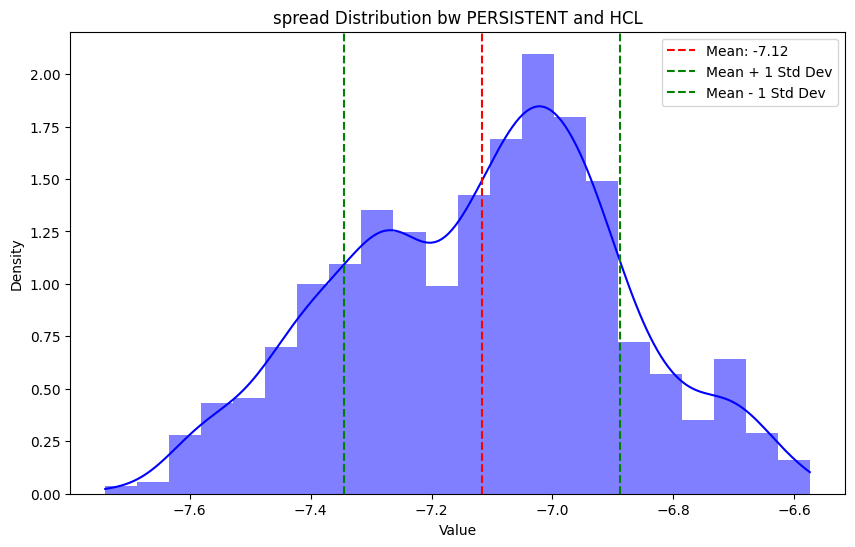

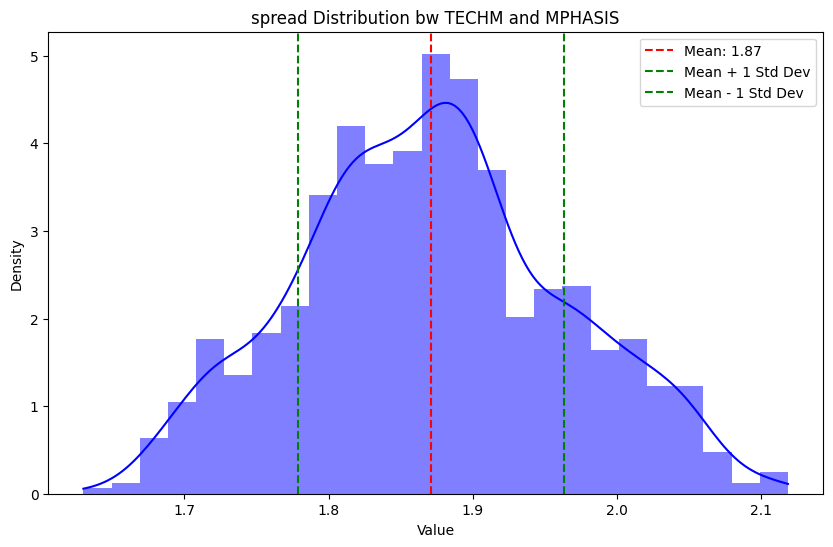

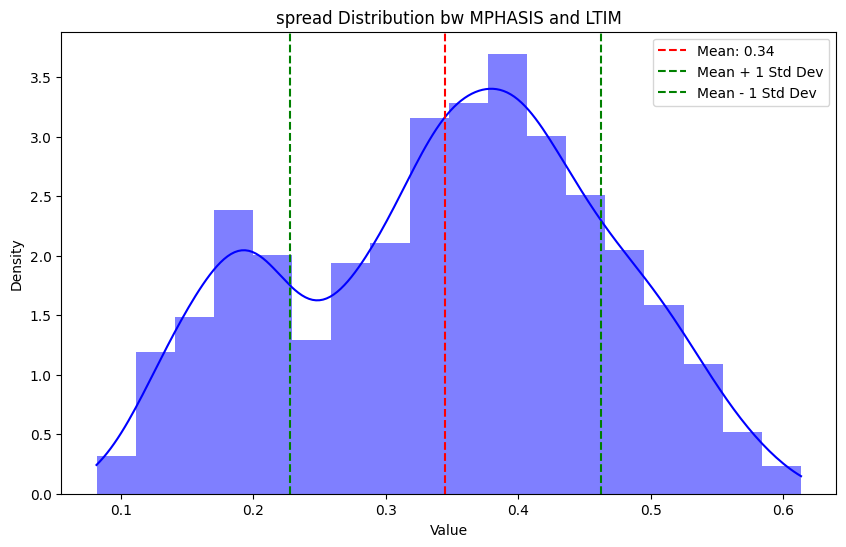

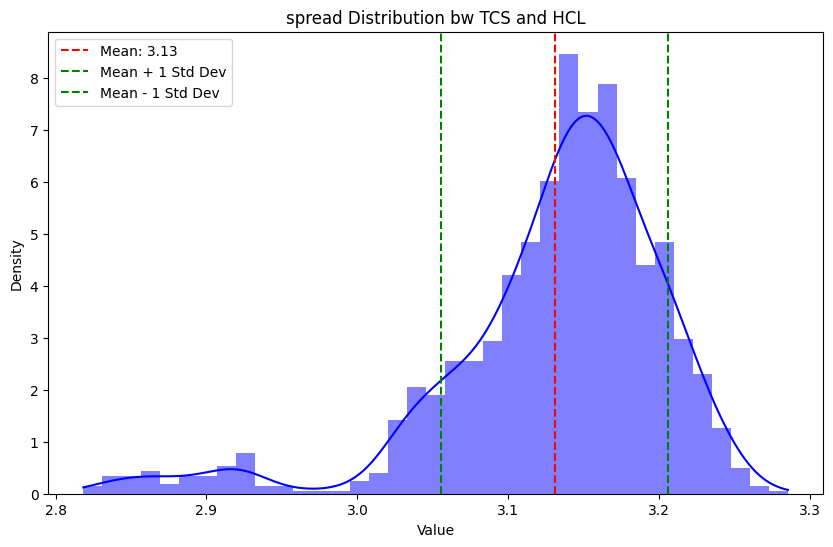

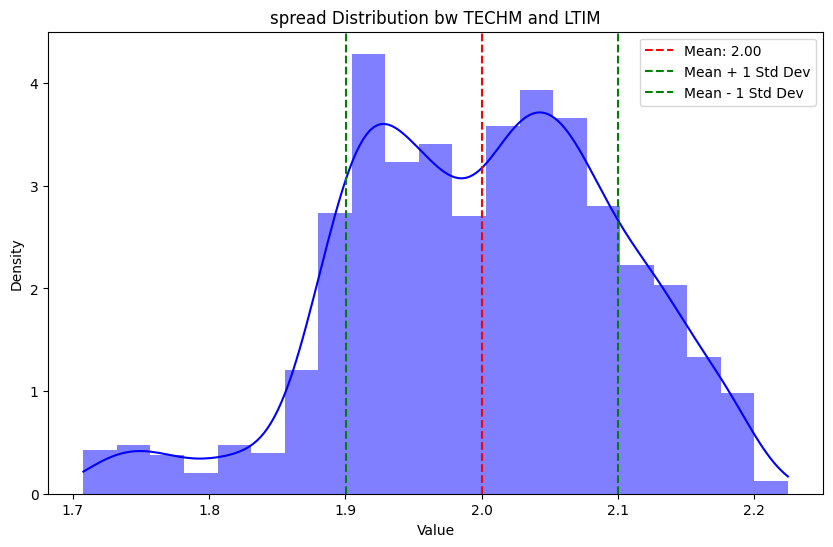

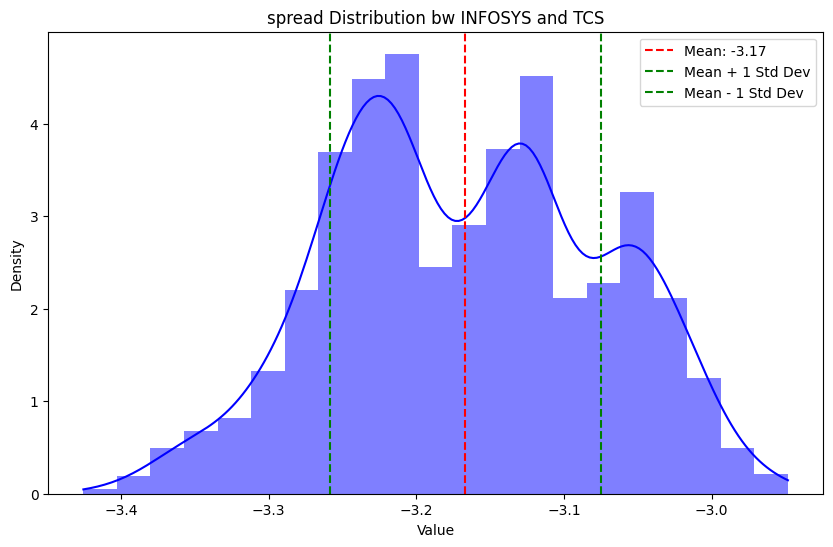

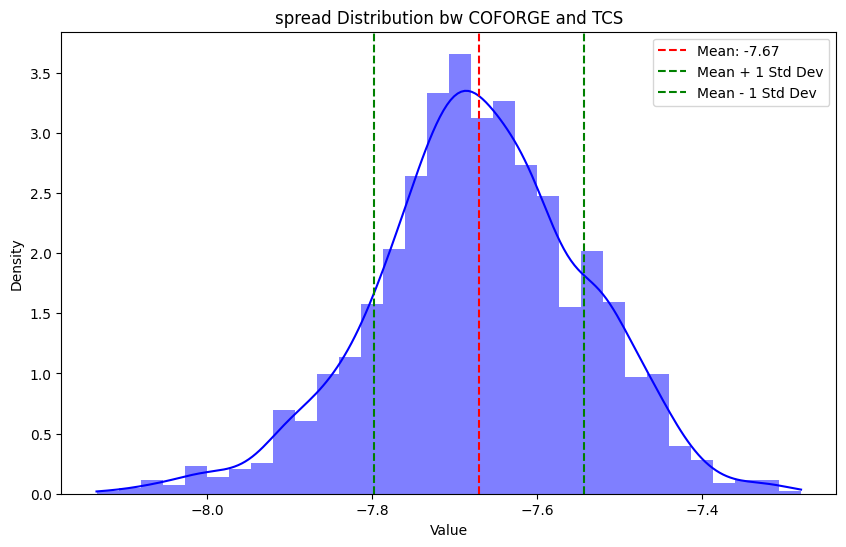

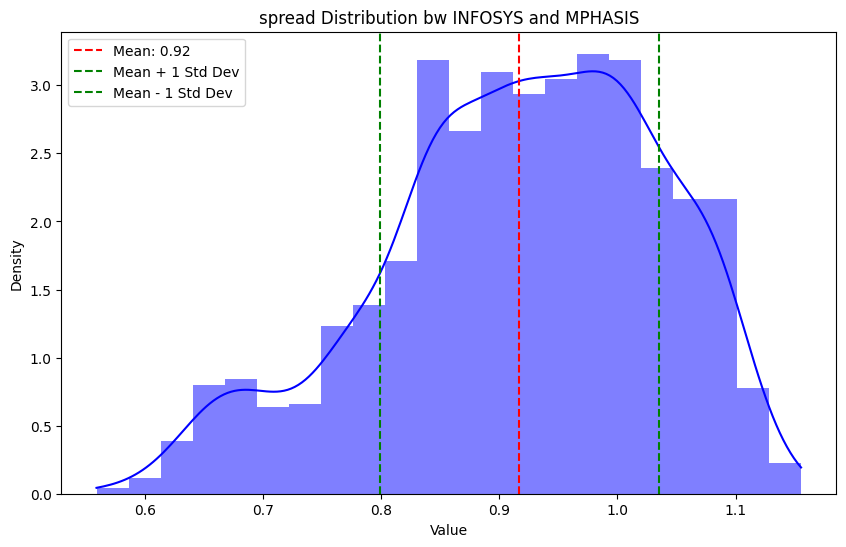

In [47]:


import matplotlib.pyplot as plt
import seaborn as sns

for i in range(len(hedge_ratio_dataframe)):


  log_prices_A = df_concat_log[hedge_ratio_dataframe.iloc[i,0]]
  log_prices_B = df_concat_log[hedge_ratio_dataframe.iloc[i,1]]
  # Hedge ratio
  n = hedge_ratio_dataframe.iloc[i,2]

  # Calculate the spread
  spread = log_prices_A - n * log_prices_B
  mean=np.mean(spread)
  std_dev=np.std(spread)


  # Example data
  data = spread

  # Create a histogram and a density plot
  plt.figure(figsize=(10, 6))

  # Plot histogram
  sns.histplot(data, kde=True, color='blue', stat='density', linewidth=0)

  # Plot the mean and standard deviation
  plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
  plt.axvline(mean + std_dev, color='green', linestyle='--', label=f'Mean + 1 Std Dev')
  plt.axvline(mean - std_dev, color='green', linestyle='--', label=f'Mean - 1 Std Dev')

  plt.title(f'spread Distribution bw {hedge_ratio_dataframe.iloc[i,0]} and {hedge_ratio_dataframe.iloc[i,1]}')
  plt.xlabel('Value')
  plt.ylabel('Density')
  plt.legend()

  plt.show()


In [ ]:
import math
current_spread=math.log(4382)-hedge_ratio*math.log(1642)
print(current_spread)

z_score_of_current_spread=(current_spread-mean)/std_dev
print(z_score_of_current_spread)

3.138320486110951
-0.1333452808337074
